In [50]:
#from utils import *
import cv2  
import rospy 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sensor_msgs.msg import Image , LaserScan , PointCloud2
import ros_numpy
import os

from geometry_msgs.msg import PoseStamped, Point , Quaternion , TransformStamped , Twist,Pose
from std_srvs.srv import Trigger, TriggerResponse 
import moveit_commander
import moveit_msgs.msg

from tf2_sensor_msgs.tf2_sensor_msgs import do_transform_cloud
import tf2_ros  
from cv_bridge import CvBridge
import tf


In [51]:
def read_tf(t):
    pose=np.asarray((
        t.transform.translation.x,
        t.transform.translation.y,
        t.transform.translation.z
        ))
    quat=np.asarray((
        t.transform.rotation.x,
        t.transform.rotation.y,
        t.transform.rotation.z,
        t.transform.rotation.w
        ))
    
    return pose, quat

def correct_points(points_msg,low=0.27,high=1000):

    # Function that transforms Point Cloud reference frame from  head, to map. (i.e. sensor coords to map coords )
    # low  high params Choose corrected plane to segment  w.r.t. head link 
    # img= correct_points() (Returns rgbd depth corrected image)    

    #data = rospy.wait_for_message('/hsrb/head_rgbd_sensor/depth_registered/rectified_points', PointCloud2)
    np_data=ros_numpy.numpify(points_msg)

    try:
        trans = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
                    
        trans,rot=read_tf(trans)
        print ("############head",trans,rot)
    except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException):
        print ( 'No  head TF FOUND')

    #trans,rot=tf_listener.lookupTransform('/map', '/head_rgbd_sensor_rgb_frame', rospy.Time(0))
    #print ("############TF1",trans,rot)


    eu=np.asarray(tf.transformations.euler_from_quaternion(rot))
    t=TransformStamped()
    rot=tf.transformations.quaternion_from_euler(eu[0],eu[1],eu[2])
    #rot=tf.transformations.quaternion_from_euler(-eu[1],0,0)
    t.header.stamp = points_msg.header.stamp
    
    t.transform.rotation.x = rot[0]
    t.transform.rotation.y = rot[1]
    t.transform.rotation.z = rot[2]
    t.transform.rotation.w = rot[3]

    cloud_out = do_transform_cloud(points_msg, t)
    np_corrected=ros_numpy.numpify(cloud_out)
    corrected=np_corrected.reshape(np_data.shape)

    img= np.copy(-corrected['z'])

    img[np.isnan(img)]=2

    img_corrected = np.where((img<trans[2]*0.96) ,img,5)
#    img_corrected = np.where((img<trans[2]+0.07)&(img>trans[2]-0.05) ,img,5)
    return img_corrected , corrected

def plot_with_cbar(image,cmap="jet"):
    ax = plt.subplot()
    im=ax.imshow(image, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

    
def segment_table(points_data,corrected,obj_lMax=0.8,plot_=False):
    if plot_:
        print("Imagen entrada en Z")
        plot_with_cbar(corrected['z'],cmap="gist_rainbow")
    zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)

    histogram, bin_edges =(np.histogram(zs_no_nans, bins=100))
    t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
    trans=t.transform.translation.z
    print(trans)
    img_corrected = np.where((-zs_no_nans < trans*0.999) ,zs_no_nans,1.0)  #FLOOR

    #print((trans*0.999)-0.72 +0.2)
    #Quita a una altura
    plane_height= (trans)+bin_edges[histogram[:-1].argmax()+1]
    img_corrected = np.where(    (-zs_no_nans <  (trans*0.999)-plane_height-0.01),zs_no_nans,1)
    if plot_:
        print("Imagen sin datos menores a altura de mesa")
        plot_with_cbar(img_corrected,cmap="gist_rainbow")
    # Quita objetos lejanos
    lenZ_no_nans=np.where(~np.isnan(points_data['z']),points_data['z'],-5)
    lenZ_corrected=np.where(lenZ_no_nans<obj_lMax,lenZ_no_nans,-5)
    if plot_:
        print(f"Imagen sin corrected en Z pero quitando si Z del sensor es mayor que {obj_lMax}")
        plot_with_cbar(lenZ_corrected,cmap="gist_rainbow")
    # quita Z en los que los X sean -5
    for r in range(img_corrected.shape[0]):
        for c in range(img_corrected.shape[1]):
            if lenZ_corrected[r,c]<=-5:
                img_corrected[r,c]=1
    if plot_:
        print(f"Im final con quitando X mayor a {obj_lMax}")
        plot_with_cbar(img_corrected,cmap="gist_rainbow")
    return img_corrected
#-----------------------------------------------------    
def segment_floor(corrected,obj_hMax=0.85,obj_lMax=1.5,plot_=True):
    # obj_hMax -> altura maxima para objetos para segmentar
    # obj_lMax -> distancia de objetos maxima para segmentar
    # Quita nan
    zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)
    if plot_:    
        print("Imagen de entrada, no nan")
        plot_with_cbar(zs_no_nans,cmap="gist_rainbow")
    
    # Quita piso y mayor a una cierta altura
    t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
    trans=t.transform.translation.z
    print("TRANS",trans,trans-obj_hMax)
    img_corrected = np.where(zs_no_nans < -(trans-obj_hMax+0.05),zs_no_nans,1)
    if plot_:
        print("AUQ",obj_hMax)
        plot_with_cbar(img_corrected,cmap="gist_rainbow")
    img_corrected = np.where((img_corrected >-trans-0.1),img_corrected,1)
    if plot_:
        plot_with_cbar(img_corrected,cmap="gist_rainbow")
    
    # Quita objetos lejanos
    xs_no_nans=np.where(~np.isnan(corrected['x']),corrected['x'],-5)
    x_corrected=np.where(xs_no_nans<obj_lMax,xs_no_nans,-5)

    # Con esto, quita en z los que en X esten con -5
    for r in range(img_corrected.shape[0]):
        for c in range(img_corrected.shape[1]):
            if x_corrected[r,c]<=-5:
                img_corrected[r,c]=1
    print(f"Salida, en Z sin datos en X mayores que {obj_lMax}")
    if plot_:
        plot_with_cbar(img_corrected,cmap="gist_rainbow")
    return img_corrected

#-----------------------------------------------------
def segment(points_data,corrected,op=0,height=0.85,lenght=1.5,plot_=False):
    # op == 0 -> floor
    # op == 1 -> table
    
    if op==0:
        print("Piso")
        return segment_floor(corrected,obj_hMax=height,obj_lMax=lenght,plot_=plot_)
    else:
        print("Mesa")
        
        return segment_table(points_data,corrected,obj_lMax=lenght,plot_=plot_)
    
def plane_seg2(points_msg,op_s=0,hg=0.85,lg=1.5,lower=100 ,higher=50000,reg_ly= 30,reg_hy=600,plot=False):
    points_data = ros_numpy.numpify(points_msg)    
    image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
    image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
    image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print (image.shape)

    _,corrected=correct_points(points_msg)
    im_corrected=segment(points_data,corrected,op=op_s,height=hg,lenght=lg,plot_=plot)
    if plot:
        print("Imagen como entrada a obtener centroides")
        plot_with_cbar(im_corrected,cmap="prism")
    contours, hierarchy = cv2.findContours(im_corrected.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):

        area = cv2.contourArea(contour)
        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            if (cY > reg_ly and cY < reg_hy  ):

                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                #image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                

                image_aux= image[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[1]+boundRect[2]]
                images.append(image_aux)
                image_aux= im_corrected[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]

                mask=np.where(image_aux!=5)
                npmask=np.asarray(mask).T
                rgb_image=cv2.rectangle(rgb_image,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,0), 2)
                cv2.circle(rgb_image, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(rgb_image, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
                print ('cX,cY',cX,cY,'len mask',len(npmask))
                xyz=[]
                if len (npmask)>0:
                    for a in npmask:
                        ix,iy=a[0],a[1]
                        aux=(np.asarray((points_data['x'][boundRect[1]+ix,boundRect[0]+iy],points_data['y'][boundRect[1]+ix,boundRect[0]+iy],points_data['z'][boundRect[1]+ix,boundRect[0]+iy])))
                        #print (aux)
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                                'reject point'
                        else:
                            xyz.append(aux)
                
                xyz=np.asarray(xyz)
                #print (xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
                
            else:   
                print ('cent out of region... rejected')
    return cents,np.asarray(points), images,rgb_image



In [52]:
# START MOVEIT IN TERMINAL BEFORE THIS 
rospy.init_node('plane_segmentation') 
tfBuffer = tf2_ros.Buffer()
tfBuffer = tf2_ros.Buffer()
listener2 = tf2_ros.TransformListener(tfBuffer)
listener = tf.TransformListener()

broadcaster = tf2_ros.TransformBroadcaster()
tf_static_broadcaster = tf2_ros.StaticTransformBroadcaster()

#tf_listener = tf.TransformListener()
#broadcaster= tf.TransformBroadcaster()
#tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()
#pub = rospy.Publisher('/segmented_images', Image, queue_size=1)
bridge=CvBridge()


In [53]:

head = moveit_commander.MoveGroupCommander('head')
arm =  moveit_commander.MoveGroupCommander('arm')

In [5]:
av= arm.get_current_joint_values()
av

[0.010000356364572603,
 7.94719811145761e-05,
 -1.570002345343694,
 -1.5700036302849658,
 -0.0003068917761841483,
 0.0]

In [6]:
hv=head.get_current_joint_values()
hv

[4.609845300418414e-05, -8.692728991976928e-05]

In [120]:
hv[1]= -1.0
hv[0]=  0.0
head.go(hv)

True

In [90]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,
                                  timeout=5)
points_data = ros_numpy.numpify(points_msg)    
image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    #hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV_FULL)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print (image.shape)


_,corrected=correct_points(points_msg)
corrected['z'].shape

(480, 640, 3)
############head [ 8.92657775 -2.34971863  1.08720208] [-0.63631102 -0.67854063  0.26770677  0.25104578]


(480, 640)

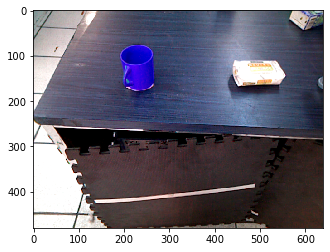

In [91]:
plt.imshow(img)

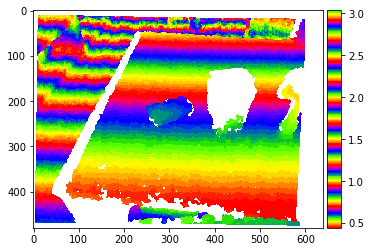

In [92]:
plot_with_cbar(points_data['z'],cmap='prism')

Piso
Imagen de entrada, no nan


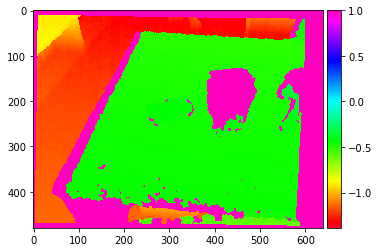

TRANS 1.0872026784232498 0.9372026784232498
AUQ 0.15


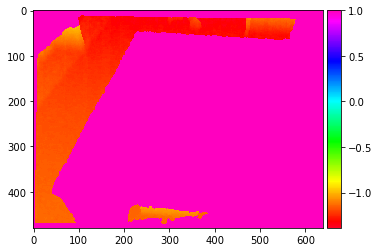

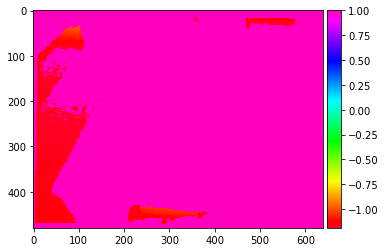

Salida, en Z sin datos en X mayores que 1.1


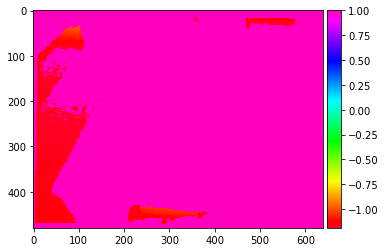

In [93]:
# FLOOR
im_corrected=segment(points_data,corrected,op=0,height=0.15,lenght=1.1,plot_=True)


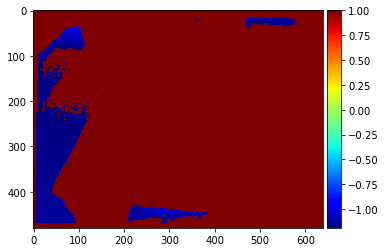

In [96]:
plot_with_cbar(im_corrected)

In [97]:
cents,xyz, images, img = plane_seg2(points_msg,op_s=1,hg=0.85,lg=0.9,
                                    lower=300, higher=6000,reg_hy=350)


(480, 640, 3)
############head [ 8.92778542 -2.35008315  1.08720291] [-0.63653231 -0.67833204  0.26762604  0.25113456]
Mesa
1.087202908691328
cX,cY 445 241 len mask 984
[0.13182378 0.01103385 0.5614102 ]
cX,cY 569 215 len mask 4223
[ 0.25936848 -0.01494469  0.56758714]


/tmp/ipykernel_43211/599292800.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cents,np.asarray(points), images,rgb_image


In [98]:
import pandas as pd
import ros_numpy
from numpy.linalg import eig
from geometry_msgs.msg import Vector3, Vector3Stamped

In [99]:
x_points, y_points,z_points=(xyz[0][:,0]).tolist(),(xyz[0][:,1]),(xyz[0][:,2]) 



In [100]:

pca_vectors,eig_val, size_obj    =pca(x_points,y_points,z_points,'frame','whatever')

In [101]:
###Eigen Vecs , eigen valores, size_obj

In [104]:
obj_pose, axis_x_obj, axis_y_obj,axis_z_obj =object_pose(cents[0].tolist(),pca_vectors[0], "whatever" )

LookupException: "realsense_link" passed to lookupTransform argument source_frame does not exist. 

In [78]:
cents[0].tolist()

[0.1895807534456253, -0.10204306989908218, 0.5536186099052429]

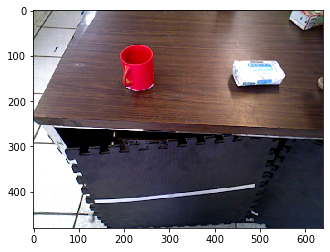

In [75]:
plt.imshow(image)aa

In [103]:
def pca(x_points, y_points, z_points, frame_id, centroide_cam):    
    """
        Expects as argument one point cloud of the contoured object in the frame_id and return
        eigenvectors and eigenvalues.
    """
    point_cloud =  {"x": x_points, "y": y_points,"z": z_points}
    # sin estandar scaler
    point_cloud = pd.DataFrame(pd.DataFrame(point_cloud), columns=["x","y","z"])
    eig_val, eig_vect = eig(point_cloud.cov())  # Eigenvalues and eigenvectors from Point Cloud Covariance Matrix

    # Ordering from largest to smallest eigenvalues
    mayor, menor = np.amax(eig_val), np.amin(eig_val)
    eig_value_list = eig_val.tolist()
    ind_M = eig_value_list.index(mayor)
    ind_m = eig_value_list.index(menor)
    ind_sec = 3 - ind_m - ind_M

    #print("M,s,m", ind_M, ind_sec, ind_m)
    # each column of eig_vect corresponds to an eigenvector
    Eig_vect = [eig_vect[:,ind_M]* np.sqrt(eig_val[ind_M]), 
                eig_vect[:,ind_sec]*np.sqrt(eig_val[ind_sec]),  
                eig_vect[:,ind_m]*np.sqrt(eig_val[ind_m])]

    m = eig_vect[:,ind_m]
    M = eig_vect[:,ind_M]
    s = eig_vect[:,ind_sec]

    #MT = np.asarray([M, s, m])  # Matriz de transformacion con eigenvectores ordenados de mayor a menor
    MT = np.asarray(eig_vect) 
    # ESTIMACION DEL TAMANIO DEL OBJETO SEGMENTADO  object_size_estimation******************
    pts_frame_PCA = pd.DataFrame(point_cloud.values @ MT,#eig_vect.T, 
                                 columns=["x","y","z"])
    
    pts_frame_PCA = pts_frame_PCA.to_numpy()
    h_min, h_max = pts_frame_PCA[0, 0] , pts_frame_PCA[-1, 0] #H[0] , H[-1]
    l_min, l_max = pts_frame_PCA[0, 1] , pts_frame_PCA[-1, 1]
    w_min, w_max = pts_frame_PCA[0, 2] , pts_frame_PCA[-1, 2]
    H = abs( h_max - h_min )
    L = abs( l_min - l_max )
    W = 2*abs( w_max - w_min )
    # Approximate size of the object is H, L, W
    size_obj = Vector3()
    size_obj.x = H
    size_obj.y = W
    size_obj.z = L
    
    return [M, s, m], [eig_val[ind_M], eig_val[ind_sec], eig_val[ind_m]], size_obj





def object_pose(centroid, principle_axis, frame_id):  # modificar a pointStamped cada punto
    """
        Esta funcion determina el frame orientacion del objeto, recibe la primera componente del 
        analisis de PCA en 'realsense_link' y devuelve un objeto Pose, ademas genera el frame obj
        EL FRAME DEBE GENERARSE EN BASE LINK... (el dia 21 de febrero)


        Construction of the coordinate system of the object
        All points is in the frame_id
    
        Pp = a random point on principle axis
        Ps = position of the frame in which the cloud points is obtained = (0,0,0)
        
        Oc_y = Oc_Ps x Oc_Pp , ahora eje x sera el de la componente principal
        Oc_z = Oc_y x Oc_x 
    """
    global listener 
    principle_axis  = np.asarray(principle_axis)    # vector in frame "realsense_link"
    # transformacion de vector en frame camera a frame base_link*************************

    v_msg = Vector3Stamped()
    v_msg.header.frame_id = 'realsense_link'   # Sistema coordenado de vector
    v_msg.header.stamp = rospy.Time(0) 
    v_msg.vector.x, v_msg.vector.y , v_msg.vector.z = principle_axis[0], principle_axis[1], principle_axis[2]
    target_frame = 'base_link'
    vector_principal_base_link = listener.transformVector3(target_frame, v_msg)

    # Cambiar punto de centroide a frame base_link*********************************************
    #centroid = points_actual_to_points_target( centroid , 'realsense_link', 'base_link')
    #centroid respecto a base link
    
    #######################################3
    #########################################
    
    
    
    
    
    principle_axis = np.asarray([vector_principal_base_link.vector.x , vector_principal_base_link.vector.y , vector_principal_base_link.vector.z ])
    
    
    if principle_axis[2] < 0: 
        principle_axis = -1 * principle_axis
    
    
    Oc_Pp  = np.asarray(principle_axis) 
    # asignamos el eje principal a eje x base link
    

    # axis x,y,z quedan en el frame base_link
    Oc_Ps = np.asarray([ centroid[0] , centroid[1] , centroid[2] ])

    Obj_y = np.cross(Oc_Ps , Oc_Pp)

    Obj_y = Obj_y /np.linalg.norm( np.cross(Oc_Ps , Oc_Pp ) )
    Obj_x = principle_axis /np.linalg.norm( principle_axis )    # Eje principal en x
    Obj_z = np.cross(Obj_y , Obj_x ) /np.linalg.norm( np.cross(Obj_x , Obj_y ) )

    axis_x_obj, axis_y_obj, axis_z_obj = Point(), Point(), Point()
    axis_x_obj.x, axis_x_obj.y, axis_x_obj.z = Obj_x[0], Obj_x[1], Obj_x[2]
    axis_y_obj.x, axis_y_obj.y, axis_y_obj.z = Obj_y[0], Obj_y[1], Obj_y[2]
    axis_z_obj.x, axis_z_obj.y, axis_z_obj.z = Obj_z[0], Obj_z[1], Obj_z[2]
    
    # con los vectores que representan a los ejes se forma la matriz de rotacion (columnas) y a partir de ella se obtienen
    # los cuaterniones necesarios para generar el frame del objeto
    comb = [[Obj_x, Obj_y , Obj_z],[Obj_y, Obj_x , Obj_z],[Obj_z, Obj_y , Obj_x],[Obj_x, Obj_z , Obj_y],[Obj_z, Obj_x , Obj_y]]
    RM = np.asarray( comb[3])
    RM = RM.T
    TM = [[RM[0,0], RM[0,1] , RM[0,2], 0],
         [RM[1,0], RM[1,1] , RM[1,2], 0],
         [RM[2,0], RM[2,1] , RM[2,2], 0], 
         [0, 0, 0, 1]]

    r,p,y = tft.euler_from_matrix(np.asarray(TM))
    q_obj = tft.quaternion_from_euler(r, p, y)
    same_tf = tft.is_same_transform(np.asarray(TM), np.asarray( tft.quaternion_matrix(q_obj)))
    print("same tf?", same_tf )

    d = np.sqrt(q_obj[0]**2 + q_obj[1]**2 + q_obj[2]**2 + q_obj[3]**2)

    obj_pose = Pose()
    obj_pose.position.x, obj_pose.position.y, obj_pose.position.z = centroid[0], centroid[1], centroid[2]
    obj_pose.orientation.x = q_obj[0]/d
    obj_pose.orientation.y = q_obj[1]/d
    obj_pose.orientation.z = q_obj[2]/d
    obj_pose.orientation.w = q_obj[3]/d

    # cambiar de frame
    #pose_base_link = frame_actual_to_frame_target(obj_pose , 'realsense_link', 'base_link')


    # la pose debe salir en el sistema base_link y cancelar la funcion de arriba

    return obj_pose , axis_x_obj, axis_y_obj, axis_z_obj , centroid

In [ ]:
pca()

(480, 640)


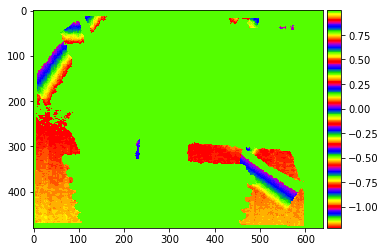

In [28]:
print(im_corrected.shape)
plot_with_cbar(im_corrected,cmap="prism")


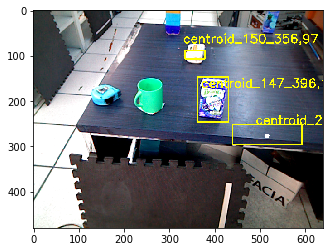

In [29]:
plt.imshow(img)

In [119]:
#hv[1]= -1.0
hv[0]= 0.7
head.go(hv)

True

############head [0.63665364 0.49572267 0.94040232] [ 9.59549114e-01 -1.91615527e-03  5.62204943e-04 -2.81534207e-01]
Piso
Imagen de entrada


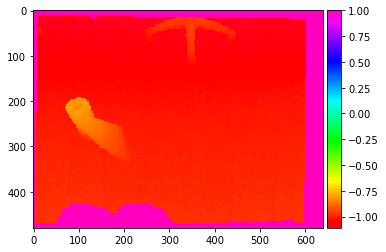

Salida, en Z sin datos en Y mayores que: 1.0


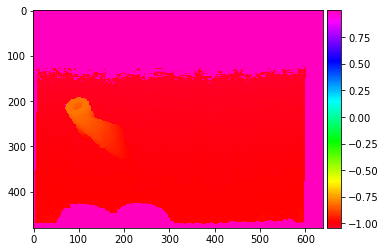

In [15]:
cents,xyz, images, img = plane_seg( points_msg,lower=150,
                                   higher=40000,reg_hy=350)
    

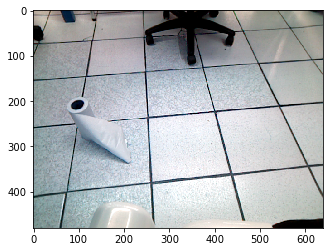

In [16]:
plt.imshow(img)

## SUP. No encontró, voltea un poco la cabeza

In [200]:
hv[1]= -1.0
hv[0]= -0.4

In [201]:
head.go(hv)

[ WARN] [1675887688.951229503]: move action server not connected


False

In [185]:
arm.set_named_target('go')
succ=arm.go()

# MESA

In [186]:
hv= head.get_current_joint_values()
hv

[4.609845300418414e-05, -0.4800269272899198]

In [27]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)
points_data = ros_numpy.numpify(points_msg)    
image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    #hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV_FULL)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print (image.shape)

_,corrected=correct_points(points_msg)
corrected['z'].shape

(480, 640, 3)
############head [-0.44030511 -0.92494276  1.01557396] [-0.31348222 -0.8270792   0.43626461  0.16535442]


(480, 640)

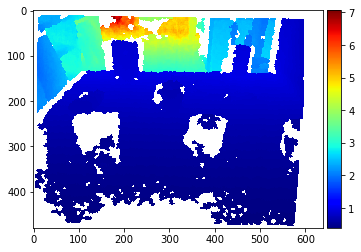

In [28]:
plot_with_cbar(points_data['z'])
#zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)
#plot_with_cbar(zs_no_nans)
#plot_with_cbar(np.where(zs_no_nans<-0.2,zs_no_nans,1))



Mesa
Imagen entrada en Z


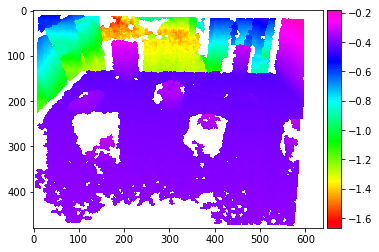

1.0155742627251612
Imagen sin datos menores a altura de mesa


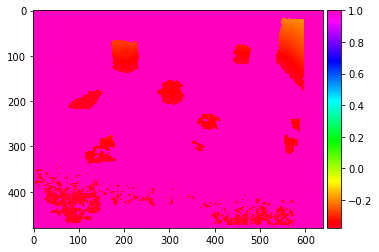

Imagen sin corrected en Z pero quitando si Z del sensor es mayor que 1.1


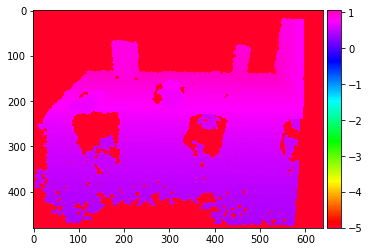

Im final con quitando X mayor a 1.1


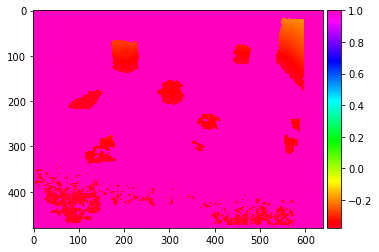

In [29]:
# TABLE
im_corrected=segment(points_data,corrected,op=1,lenght=1.1,plot_=True)


(480, 640)


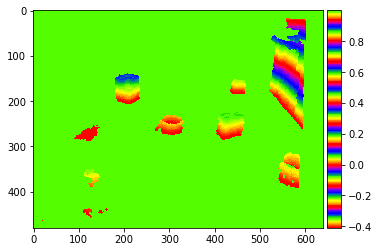

In [61]:
print(im_corrected.shape)
plot_with_cbar(im_corrected,cmap="prism")

In [5]:
lower=300
higher=8000
reg_ly= 30
reg_hy=600
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)

cents,xyz, images, img = plane_seg2(points_msg,op_s=1,lg=0.9,lower=300, higher=9000,reg_ly=0,reg_hy=350,plot=True)


ROSException: timeout exceeded while waiting for message on topic /hsrb/head_rgbd_sensor/depth_registered/rectified_points

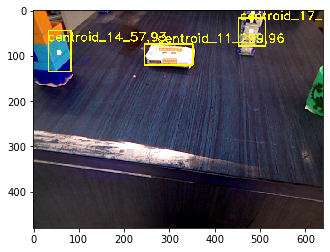

In [57]:
plt.imshow(img)

In [105]:
from utils.grasp_utils import *
from utils.misc_utils import *
from utils.nav_utils import *


ModuleNotFoundError: No module named 'utils.grasp_utils'; 'utils' is not a package